In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# import sys
# !{sys.executable} -m pip install pycbc ligo-common emcee==2.2.1 'numpy<=1.23.0' --no-cache-dir

# One-dimensional Analytical Model

**How to estimate a single parameter using an analytical model. Example: Normal distribution.**

**This is an analytical model that we employ largely for testing the capabilities of different samplers. This will create a "likelihood" surface in one-dim (x) with zero mean and unit variance.**

In [3]:
from pycbc.inference import models
from pycbc.distributions import Uniform

my_model = models.TestNormal(('x'), mean = (0))

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


**We need to choose a sampler. in this case "emcee". Provide the model we are using along with the prior and number of walks. Emcee is "ensemble" sampler so it consists of many points which are traversing the space and help each other explore the likelihood surface.**

In [4]:
from pycbc.inference import sampler
engine = sampler.EmceeEnsembleSampler(my_model, nwalkers = 1000, nprocesses = 8)

**Before we start we need to decide the initial positions of the walkers In this case we choose that they be distributed randomly between -1 and 1. We use the 'Uniform' distribution class.**

In [5]:
_ = engine.set_p0(prior = (Uniform(x = (-1, 1))))

In [6]:
engine.run_mcmc(200)

**We can get the entire history of where the "walkers" have been by looking at the samples attribute. For each variable parameter, we get an array with dimensions nwalkers x num_iterations. This is the format for the 'Emcee' sampler.**

In [7]:
import pylab, numpy

xchain = engine.samples['x'] # Dimensions -> 1000 X 200 (NWalkers X numIterations)

**The chain has 2 dimensions, the first axis is the walker and the second is the iteration. We'll plot the final position of each walker**

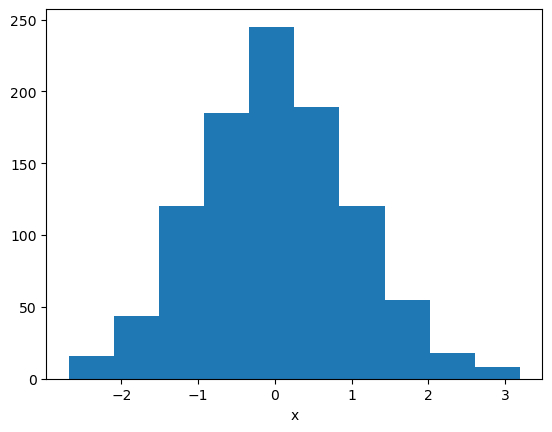

0.013164240588304298 1.010798581812796


In [8]:
values = xchain[:, -1]

pylab.hist(values)
pylab.xlabel('x')
pylab.show()

print(values.mean(), numpy.var(values))

# Higher Dimensions

In [9]:
from pycbc.inference import models
from pycbc.distributions import Uniform

my_model = models.TestNormal(('x', 'y'), mean = (0, 2))

In [10]:
from pycbc.inference import sampler
engine = sampler.EmceeEnsembleSampler(my_model, nwalkers = 1000, nprocesses = 8)

**Notice how the following differs from before. We are setting a uniform distribution for each parameter. This is used to set the intitial position of the walkers.**

In [11]:
pos = Uniform(x = (-1, 1), 
              y = (-1, 1))

engine.set_p0(prior = pos)

# Run the mcmc for 200 iterations
engine.run_mcmc(200)

0.02477357052971753 0.9929122312790776
2.0538797709116334 1.0148411755299522


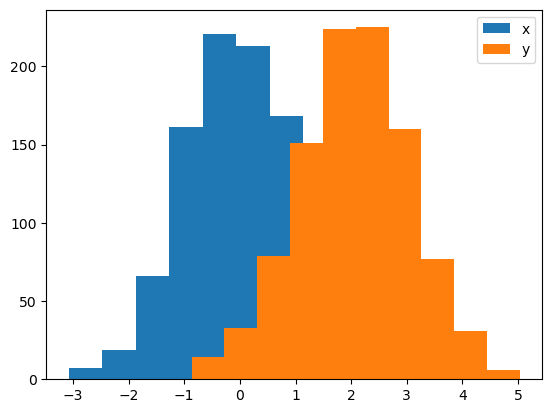

In [12]:
import pylab, numpy

# When we have multiple parameters, we can just access each by name as
# samples is a dictionary.

for param in ['x', 'y']:
    values = engine.samples[param][:, -1]
    pylab.hist(values, label = param)
    pylab.legend()
    
    print(values.mean(), numpy.var(values))

## Changing the number of dimensions of the normal distribution and find the distribution of each.

In [13]:
my_model = models.TestNormal(('w', 'x', 'y', 'z'), mean = (0, 2, 4, 6))

engine = sampler.EmceeEnsembleSampler(my_model, nwalkers = 1000, nprocesses = 8)
pos = Uniform(w = (-1, 1), x = (-1, 1), y = (-1, 1), z = (-1, 1))
engine.set_p0(prior = pos)

# Run the mcmc for 200 iterations
engine.run_mcmc(200)

0.07069829913846176 0.9964261646810448
2.0231352462208303 0.9889426608564027
3.954696090589032 0.8848034367513011
5.9776694440885745 1.0180836975572207


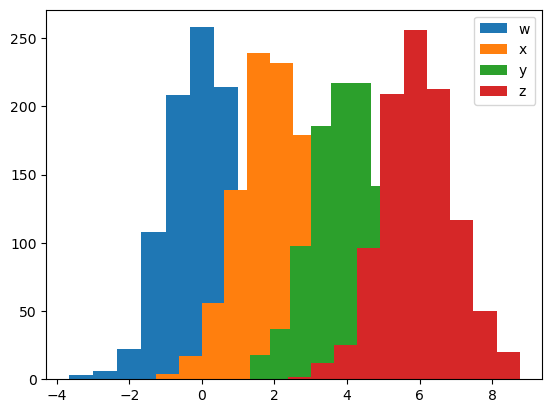

In [14]:
for param in ['w', 'x', 'y', 'z']:
    values = engine.samples[param][:, -1]
    pylab.hist(values, label = param)
    
    pylab.legend()
    
    print(values.mean(), values.var())

## Other Analytical Distributions: models.TestVolcano()

In [15]:
my_model = models.TestVolcano(('x', 'y'))

engine = sampler.EmceeEnsembleSampler(my_model, nwalkers = 1000, nprocesses = 8)
pos = Uniform(x = (-1, 1), y = (-1, 1))

engine.set_p0(prior = pos)

engine.run_mcmc(200)

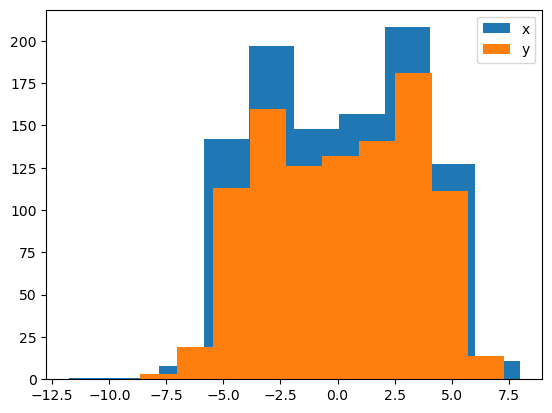

In [16]:
for param in ['x', 'y']:
    values = engine.samples[param][:, -1]
    pylab.hist(values, label = param)
    
    pylab.legend()

# Making a Simple Model

## Making own analytical model

**Each model inherits from BaseModel. We can make our own custom Model by inheriting from this class. We are required to define a single method (_loglikelihood). Other methods are provided by the base class.**

In [17]:
from pycbc.inference.models.base import BaseModel
from scipy.stats import norm

class ExampleModel(BaseModel):
    
    def __init__(self, param_name, **kwargs):
        
        # Initialize the base model. It needs to know what the variables
        # parameters are, given here as (param_name)
        super(ExampleModel, self).__init__((param_name), **kwargs)
        self.param_name = param_name
    
    def _loglikelihood(self):
        # self.current_params is a dictinonary of the parameters
        # we need to evaluate the log(likelihood) for. The name
        # of the parameters are the ones we gave to the BaseModel init method
        # in the 'super' command above.
        pos = self.current_params[self.param_name]
        
        # We are using the logpdf for the normal distribution from scipy
        return norm.logpdf(pos)

In [18]:
my_model = ExampleModel('x')

engine = sampler.EmceeEnsembleSampler(my_model, nwalkers = 1000, nprocesses = 12)
engine.set_p0(prior = Uniform(x = (-1, 1)))
engine.run_mcmc(200)

(array([  3.,  24.,  63., 155., 267., 239., 156.,  68.,  18.,   7.]),
 array([-3.34995405, -2.68418086, -2.01840768, -1.35263449, -0.68686131,
        -0.02108812,  0.64468506,  1.31045825,  1.97623143,  2.64200462,
         3.3077778 ]),
 <BarContainer object of 10 artists>)

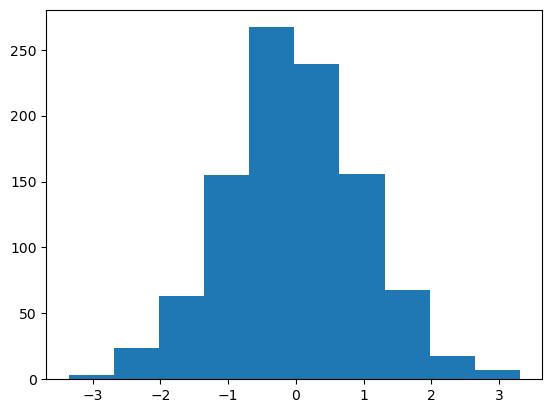

In [19]:
xchain = engine.samples['x']
values = xchain[:, -1]
pylab.hist(values)

# Making analytical model that uses data

**We can pass data to a model. We'll have samples which are drawn from an unkown normal distribution and try to estimate the distribution parameters (i.e. the mean and standard deviation). This model will contain two parameters, but for simplicity we fill the parameter names in the model as seen below.**

In [20]:
from pycbc.inference.models.base import BaseModel
from scipy.stats import norm
import numpy

class ExampleModel(BaseModel):
    
    def __init__(self, data, **kwargs):
        
        # We'll used fixed param names
        params = ('sigma', 'mean')
        
        super(ExampleModel, self).__init__(params, **kwargs)
        self.data = data
    
    def _loglikelihood(self):
        
        # self.current_params is a dictionary of the parameters 
        # we need to evaluate the log(likelihood) for.
        sigmasq = self.current_params['sigma'] ** 2.0
        mean = self.current_params['mean']
        n = len(self.data)
        
        # log likihood for a normal distribution
        loglk = -n / 2.0 * numpy.log(2 * numpy.pi * sigmasq)
        loglk += - 1. / (2 * sigmasq) * ((self.data - mean)**2.0).sum()
        return loglk

# Create some synthetic data
numpy.random.seed(10)
data = norm.rvs(size=10000)
my_model = ExampleModel(data)

In [21]:
engine = sampler.EmceeEnsembleSampler(my_model, nwalkers = 100, nprocesses = 8)
pos = Uniform(sigma = (.5, 2), mean = (-1, 1))
engine.set_p0(prior = pos)

engine.run_mcmc(400)

(array([ 3.,  4., 13., 13., 13., 21., 16.,  8.,  6.,  3.]),
 array([0.97320991, 0.976395  , 0.97958009, 0.98276518, 0.98595027,
        0.98913535, 0.99232044, 0.99550553, 0.99869062, 1.00187571,
        1.0050608 ]),
 <BarContainer object of 10 artists>)

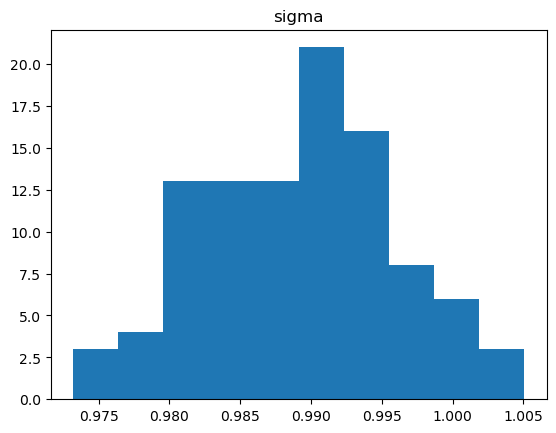

In [22]:
xchain = engine.samples['sigma']
values = xchain[:,-1]  

pylab.figure()
pylab.title('sigma')
pylab.hist(engine.samples['sigma'][:,-1])

Text(0.5, 1.0, 'mean')

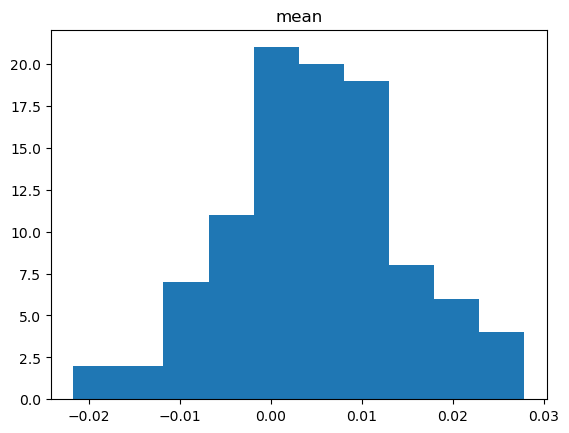

In [23]:
pylab.figure()
pylab.hist(engine.samples['mean'][:,-1])
pylab.title('mean')

In [24]:
xchain

array([[1.86648808, 1.86648808, 1.85795588, ..., 0.9886059 , 0.98607762,
        0.98607762],
       [1.52173501, 1.48213257, 1.48213257, ..., 0.99742803, 0.9931814 ,
        0.99229826],
       [1.92692752, 1.92692752, 1.92692752, ..., 0.97517413, 0.97192035,
        0.97320991],
       ...,
       [0.54093807, 0.54093807, 1.0673816 , ..., 0.98759637, 0.98972482,
        0.98945714],
       [1.8316132 , 1.8316132 , 1.56667059, ..., 0.99612565, 0.99257276,
        0.99257276],
       [1.75112505, 1.75112505, 1.75112505, ..., 0.9834044 , 0.98761093,
        0.98318244]])

# Using a model with priors

**We can create different priors for each parameter some distributions can also support multiple correlated parameters.**

In [25]:
from pycbc.distributions import Gaussian, Uniform, JointDistribution

prior_sigma = Gaussian(sigma = (0.5, 2), sigma_mean = 1, sigma_var = 0.1)
prior_mean = Uniform(mean = (-1, 1))

**Independent priors can be combined into a single joint distribution for our entire problem**

In [26]:
prior = JointDistribution(['sigma', 'mean'], prior_sigma, prior_mean)

numpy.random.seed(10)
data = norm.rvs(10000)

my_model = ExampleModel(data, prior = prior)
enigne = sampler.EmceeEnsembleSampler(my_model, nwalkers = 100, nprocesses = 8)

engine.set_p0(prior = prior)
engine.run_mcmc(400)

Text(0.5, 1.0, 'mean')

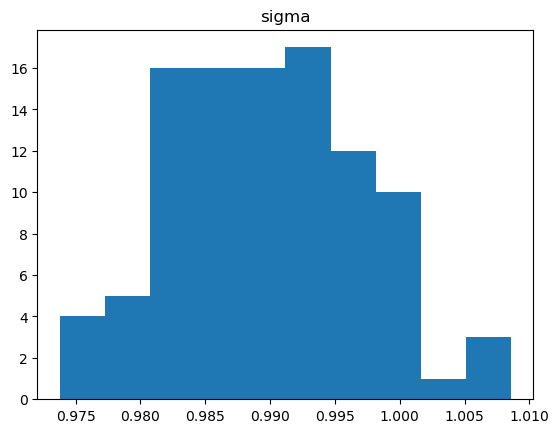

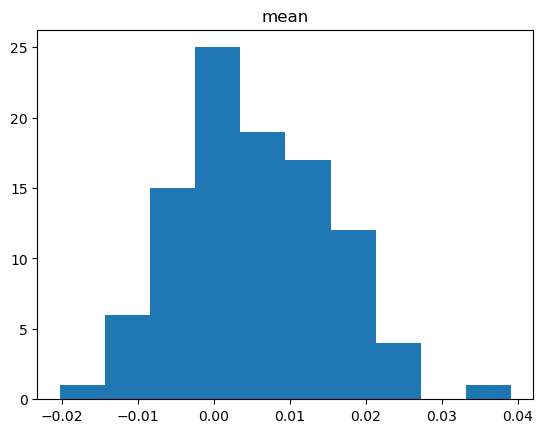

In [27]:
xchain = engine.samples['sigma']
values = xchain[:,-1]  

pylab.figure()
pylab.title('sigma')
pylab.hist(engine.samples['sigma'][:,-1])

pylab.figure()
pylab.hist(engine.samples['mean'][:,-1])
pylab.title('mean')

# Estimating the Distance of GW170917

**Single Template Model: This model is useful when we know the intrinsic parameters of a source (i.e., component masses, spins), but we don't know the extrinsic parameters (i.e., sky location, distance, binary orientation). This will allows us to estimate the distance of GW170817 and the inclination of the orbital plan from our viewing angle.**

**SingleTemplate model requires: <li>Dictinary of frequency-domain data (keyed by observatory short name such as H1, L1, V1).</li><li>Dictionary of Power Spectral Density Estimates</li><li>Low Frequency cutoff to use for internal filtering in the model.</li>**

In [28]:
from pycbc.catalog import Merger
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.frame import read_frame
from pycbc.filter import highpass, resample_to_delta_t
from astropy.utils.data import download_file

m = Merger("GW170817")

ifos = ['H1', 'L1', 'V1']

psds = {}
data = {}

for ifo in ifos:
    print("Processing {} data".format(ifo))
    
    url = "https://dcc.ligo.org/public/0146/P1700349/001/{}-{}1_LOSC_CLN_4_V1-1187007040-2048.gwf"
    fname = download_file(url.format(ifo[0], ifo[0]), cache=True) 
    
    ts = read_frame(fname, "{}:LOSC-STRAIN".format(ifo), start_time = int(m.time - 260), end_time = int(m.time + 40))
    
    ts = highpass(ts, 15.0)                     # Remove low frequency content
    ts = resample_to_delta_t(ts, 1.0/2048)      # Resample data to 2048 Hz
    ts = ts.time_slice(m.time-112, m.time + 16) # Limit to times around the signal
    data[ifo] = ts.to_frequencyseries()         # Convert to a frequency series by taking the data's FFT
    
    # Estimate the psd of the data
    psd = interpolate(ts.psd(4), ts.delta_f)
    psd = inverse_spectrum_truncation(psd, int(4 * psd.sample_rate), trunc_method = 'hann', low_frequency_cutoff = 20.0)
    
    psds[ifo] = psd

Processing H1 data
Processing L1 data
Processing V1 data


**A number of parameters must also be provided as 'static' parameters. These include <li>mass1 (Units in solar masses)</li><li>mass2 (Units in solar masses)</li><li>f_lower (used for where to start our gravitational waveform model generation from) approximant (This sets which waveform model we are using)</li>**

**If a model supports other intrinsic parameters (such as components spins), they may also optionally be provided.**

**There are also a fixed set of 'variable' parameters. These are the only ones which we can obtain estimates of with this model. These are**

**ra (Units in radians)<br>dec (Units in radians)<br>distance (Units in Megaparsecs)<br>inclination (Units in radians)<br>polarization (Units in radians)<br>tc (Units in seconds): This parameter is roughly the time of merger.**

**It's important to note that anything which could be a variable paramater, can be transformed into a static parameter by supplying a specific value for it. We take advantage of this below to limit our analyis to only sample over 'distance', 'inclination', and 'tc'. We set the sky location to the location of NGC 4993, the galaxy where an electromagnetic counterpart to GW170817 was observed.**

In [29]:
from pycbc.inference import models, sampler
from pycbc.distributions import Uniform, JointDistribution, SinAngle
import numpy

static = {'mass1':1.3757,
          'mass2':1.3757,
          'f_lower':25.0,
          'approximant':"TaylorF2",
          'polarization':0,
          'ra': 3.44615914,
          'dec': -0.40808407
         }

variable = ('distance',
            'inclination',
            'tc')

prior = JointDistribution(variable, SinAngle(inclination = None), Uniform(distance = (10, 100), tc = (m.time-.2, m.time+0.2)))

**We are not ready to create our SingleTemplate model instance. Note how the variable and static parameters are passed to the model. This is a common way this information can be passed for built-in pycbc inference models.**

**Notice that we are no longer using the Emcee sampler. While Emcee is sufficient for many problems, EmceePT, a parallel tempered version of Emcee is more effective at most gravitational-wave data analysis problems. There is one additional parameter we need to give to EmcceePT which is the number of temperatures. The output of this sampler will thus be 3-dimensional (temps x walkers x iterations). The 'coldest' temperature (0) will contain our actual results.**

In [30]:
import copy

model = models.SingleTemplate(variable, copy.deepcopy(data), low_frequency_cutoff = {'H1':25, 'L1':25, 'V1':25}, 
                              psds = psds, static_params = static, prior = prior, sample_rate = 8192)

smpl = sampler.EmceePTSampler(model, ntemps = 3, nwalkers = 200, nprocesses = 12)
_ = smpl.set_p0() # # If we don't set p0, it will use the models prior to draw initial points!

In [31]:
# Note it may take ~1-3 minutes for this to run
smpl.run_mcmc(200)

**In addition to the sampled parameters, we can also get the likelihood values our model produces. We don't go into it here, but it is also possible for models to make arbitary auxiliary information about each sample available.**

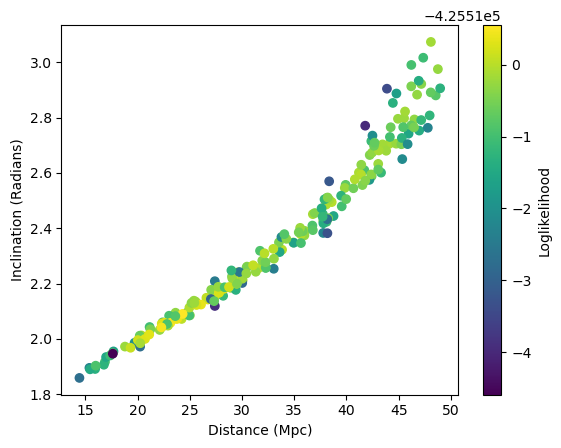

In [32]:
lik = smpl.model_stats['loglikelihood']
s = smpl.samples

# Note how we have to access the arrays differently that before since there is an additional dimension. 
# The zeroth element of that dimension represents the 'coldest' and is the one we want for our results.
# The other temperatures represent a modified form of the likelihood that allows walkers to traverse
# the space more freely.
pylab.scatter(s['distance'][0,:,-1],
              s['inclination'][0,:,-1],
              c=lik[0,:,-1])
pylab.xlabel('Distance (Mpc)')
pylab.ylabel('Inclination (Radians)')

c = pylab.colorbar()
c.set_label('Loglikelihood')
pylab.show()

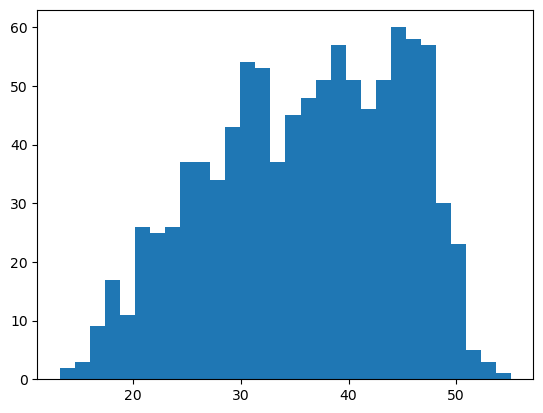

In [33]:
_ = pylab.hist(s['distance'][0,:,-100::20].flatten(), bins=30)

## Watch how the position of the walkers evolves in time

**We can see how our ensemble of walkers evolves with time using the animation utilities of matplotlib. We haven't covered the concept of "burn-in" in this tutorial, however, if you watch the animation, you can see the point that the distribution is effectively burned-in.**

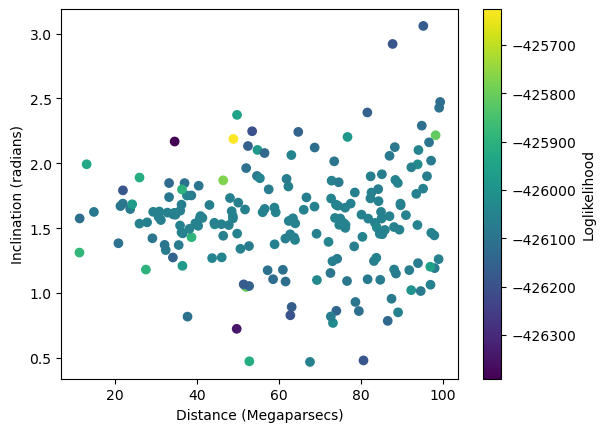

In [34]:
%matplotlib inline
from matplotlib import animation
import pylab

# We'll plot the initial position of the walkers
fig = pylab.figure(10)
a = pylab.scatter(s['distance'][0,:,0],
                  s['inclination'][0,:,0],
                  c=lik[0,:,0])
pylab.xlabel('Distance (Megaparsecs)')
pylab.ylabel('Inclination (radians)')
c = pylab.colorbar()
c.set_label('Loglikelihood')

# This function will update the plot with the ith iteration of our mcmc chain.
def animate(i):
    dat = numpy.array([s['distance'][0,:,i], s['inclination'][0,:,i]])
    a.set_offsets(dat.T)
    a.set_array(lik[0,:,i])
    return (a, )
    
nsamples = len(s['distance'][0,0,:])
ani = animation.FuncAnimation(fig, animate, frames=nsamples,
                              interval=200, blit=True)

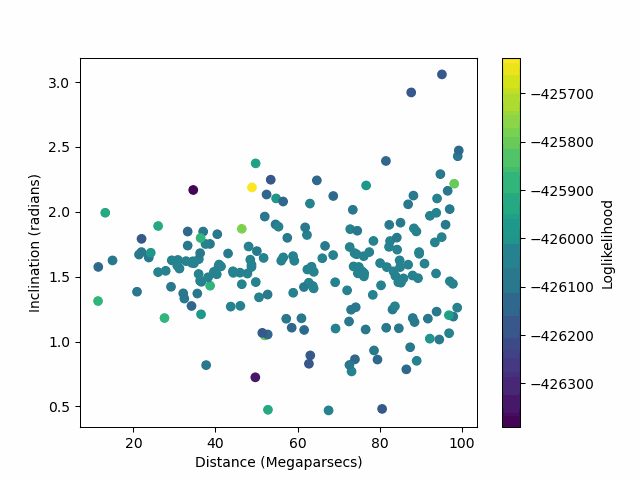

In [35]:
from matplotlib.animation import PillowWriter
from IPython.display import Image

# Note to get this to play, you may need to right click on the image and
# download to your computer or open the image in a new tab of your browser
ani.save('move.gif', writer=PillowWriter(fps=5))
with open('move.gif','rb') as f:
    display(Image(data=f.read(), format='png'))

# Estimating the sky locations of GW170817

**Estimating the sky location of the source from the gravitational-wave data alone**

In [36]:
from pycbc.inference import sampler, models
from pycbc.distributions import Uniform, JointDistribution, SinAngle, UniformSky

static = {'mass1':1.3757,
          'mass2':1.3757,
          'f_lower':25.0,
          'approximant':"TaylorF2",
          'polarization':0,
         }

variable = ('distance',
            'inclination',
            'tc',
            'ra',
            'dec',
            )

The Uniformsky distribution is a probability distribution used **to model the location of a gravitational wave source in the sky**. It **assumes** that the source could be located at any point on the celestial sphere with equal probability. This distribution is **often used as a prior distribution for the sky location parameter in Bayesian inference analyses** of gravitational wave data, where the goal is to estimate the most likely sky location of the source given the data and our prior knowledge.

**The Uniformsky distribution is defined mathematically as:**

**p(ra, dec) = 1/(4*pi), where ra is the right ascension (longitude) and dec is the declination (latitude) of the source on the celestial sphere, and pi is the mathematical constant pi.**

**This means that the probability density of the source being at any given point on the celestial sphere is proportional to a constant (1/(4*pi)), which ensures that the probability of the source being located anywhere on the sphere sums to 1.**

In [39]:
prior = JointDistribution(variable, Uniform(inclination = (2, numpy.pi), distance = (20, 50), tc = (m.time+0.02, m.time+0.05)), 
                          UniformSky()) # # This is a custom distribution which expects ra / dec and creates a isotropic distribution

In [40]:
import copy
model = models.SingleTemplate(variable, copy.deepcopy(data),
                              low_frequency_cutoff={'H1':25, 'L1':25, 'V1':25},
                              psds = psds,
                              static_params = static,
                              prior = prior,
                              sample_rate = 8192,
                              )
smpl = sampler.EmceePTSampler(model, 3, 200, nprocesses=8)
_ = smpl.set_p0()

# Note it may take a few minutes for this to run
smpl.run_mcmc(200)

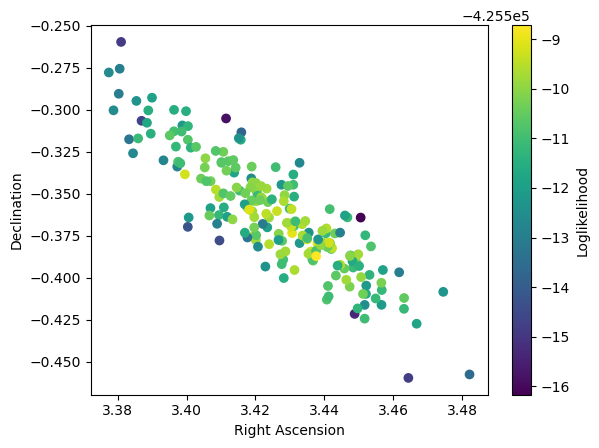

In [41]:
lik = smpl.model_stats['loglikelihood']
s = smpl.samples

# Note how we have to access the arrays differently that before since there is an additional dimension. 
# The zeroth element of that dimension represents the 'coldest' and is the one we want for our results.
# The other temperatures represent a modified form of the likelihood that allows walkers to traverse
# the space more freely.
pylab.scatter(s['ra'][0,:,-1],
              s['dec'][0,:,-1],
              c=lik[0,:,-1])
pylab.xlabel('Right Ascension')
pylab.ylabel('Declination')

c = pylab.colorbar()
c.set_label('Loglikelihood')
pylab.show()

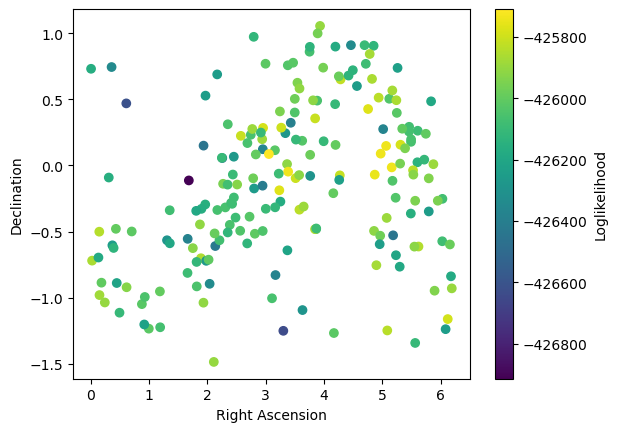

In [42]:
%matplotlib inline
from matplotlib import animation
from matplotlib.animation import PillowWriter
from IPython.display import Image
import pylab

# We'll plot the initial position of the walkers
fig = pylab.figure(11)
a = pylab.scatter(s['ra'][0,:,0],
                  s['dec'][0,:,0],
                  c=lik[0,:,0])
pylab.xlabel('Right Ascension')
pylab.ylabel('Declination')
c = pylab.colorbar()
c.set_label('Loglikelihood')

# This function will update the plot with the ith iteration of our mcmc chain.
def animate(i):
    dat = numpy.array([s['ra'][0,:,i], s['dec'][0,:,i]])
    a.set_offsets(dat.T)
    a.set_array(lik[0,:,i])
    return (a, )
    
nsamples = len(s['ra'][0,0,:])
ani = animation.FuncAnimation(fig, animate, frames=nsamples,
                              interval=200, blit=True)

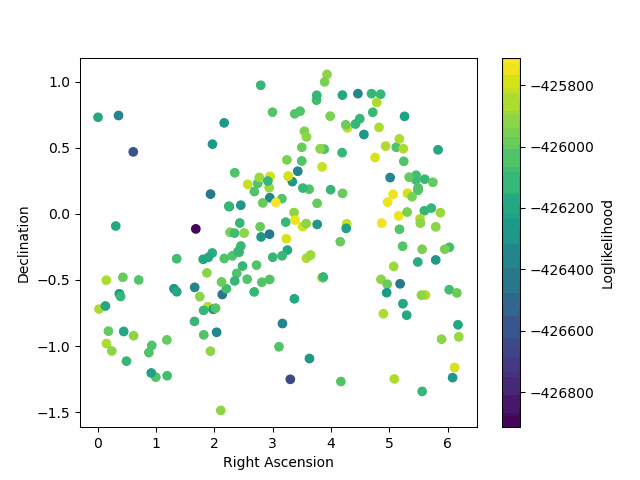

In [43]:
ani.save('move2.gif', writer=PillowWriter(fps=5))
with open('move2.gif','rb') as f:
    display(Image(data=f.read(), format='png'))